This notebook will load our 3 subjects' data, correct for the photosensor time delay, and perform stimulus-locked epoching in order to see if we got a P3b.
<br><br>
Our pre-processing will be standard:<br>
* Load data and correct for time delay (note: this is only definitely valid on stimulus-locked)
    * Also add channel information
* Re-reference our data to the average of the "mastoids" (T5 & T6)
* Apply a bandpass filter from 0.1 to 30 Hz
* Epoch to targets and non-targets and baseline correct single trials
    * It seems like my dataset had errors in it and all trials were 40%..?
    * So we'll just epoch all of our trials 
* Perform automatic simple-voltage thresholding to remove blinks
* Compute and plot grand-average ERPs

Note: No

In [1]:
import ezbci as ez
import numpy as np
import matplotlib.pyplot as plt
import pyxdf

In [2]:
# T5 was online REF, AFz GND
channels = {'Fp1':0, 'Fz':1, 'Cz':2, 'CPz':3, 'Pz':4, 'O1':5, 'O2':6, 'T6':7}

Designing FIR Hamming-window filter...
Odd order given; new order is 300
Filtering data...
Filtering completed!
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
Designing FIR Hamming-window filter...
Odd order given; new order is 300
Filtering data...
Filtering completed!
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
WARNING -- EVENT NOT WITHIN dt OF ANY EEG TIMES
Designing FIR Hamming-window filter...
Odd order given; new order is 300
Filtering data...
Filtering completed!


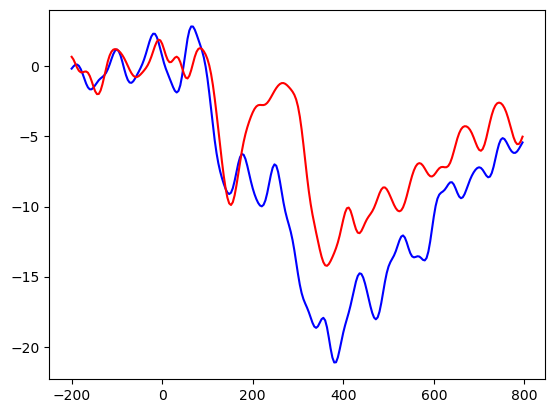

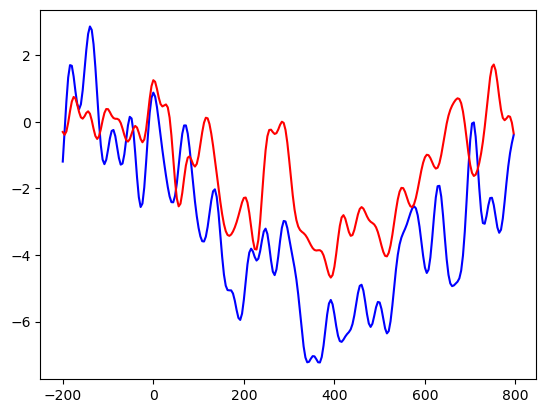

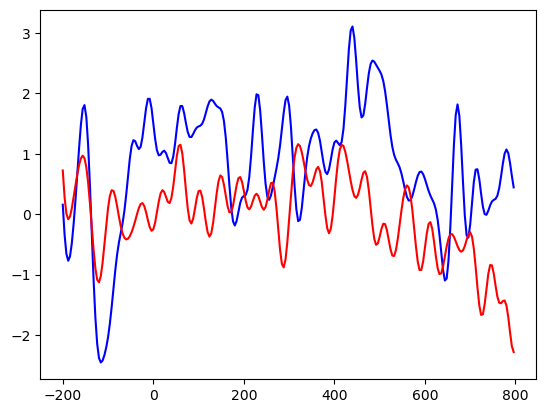

In [3]:
data_dir = '../data/raw_data/'

time_delays = {'1':534.05, '2':519.93, '3':514.79}

lo_cut = 0.1  # Hz
hi_cut = 30.0 # Hz
num_coeffs = 301
epoch_s = -200
epoch_e = 800
bl_s = -200
bl_e = 0

GA_tar = []
GA_non_tar = []
for i in range(1, 4):
    # Load data
    fname = f'816336-00000{i}_p300.xdf'
    EEG = ez.loadxdf(f'{data_dir}{fname}', False)
    
    # Apply channel values
    EEG['channels'] = channels

    # Correct for the LSL delay
    delay = np.round(time_delays[f'{i}'] * (EEG['fs']/1000)).astype(int)
    EEG['eeg_time'] = EEG['eeg_time'][0:-delay]
    EEG['eeg_data'] = EEG['eeg_data'][delay:]
    
    # Re-reference data to average of T5 and T6
    #   Note: I don't have re-referencing implemented using average of existing ref,
    #         so we'll have to re-ref. twice
    EEG = ez.reference(EEG, len(EEG['channels']), 'T5', ['Cz']) # temp
    EEG = ez.reference(EEG, len(EEG['channels']), 'Cz', ['T5', 'T6'])
    
    # Bandpass from 0.1 to 55 to remove slow drift and line noise
    EEG = ez.filter_eeg(EEG, lo_cut, hi_cut, num_coeffs, [x for x in range(len(EEG['channels']))], 'firwin', causal=False)
    
    # Epoch targets and non-targets
    tars     = ez.epoch(EEG, epoch_s, epoch_e, bl_s, bl_e, None, r'S_target_.*')
    non_tars = ez.epoch(EEG, epoch_s, epoch_e, bl_s, bl_e, None, r'S_non-target_.*')
    
    # Perform SVT and continue on good trials only
    good_tars, _, _     = ez.svt(tars['bin_data'], len(tars['channels']), -100, 100, 0, tars['bin_data'].shape[1])
    good_non_tars, _, _ = ez.svt(non_tars['bin_data'], len(non_tars['channels']), -100, 100, 0, non_tars['bin_data'].shape[1])
    
    # Compute averages at Pz and plot per subject
    ch_Pz = np.where(np.array(list(EEG['channels'])) == 'Pz')[0][0]
    avg_tars     = np.mean(good_tars[ch_Pz, :, :], 1)
    avg_non_tars = np.mean(good_non_tars[ch_Pz, :, :], 1)
    GA_tar.append(avg_tars)
    GA_non_tar.append(avg_non_tars)
    
    plt.figure()
    plt.plot(tars['bin_times'], avg_tars, 'b', label='Targets')
    plt.plot(tars['bin_times'], avg_non_tars, 'r', label='Non-targets')

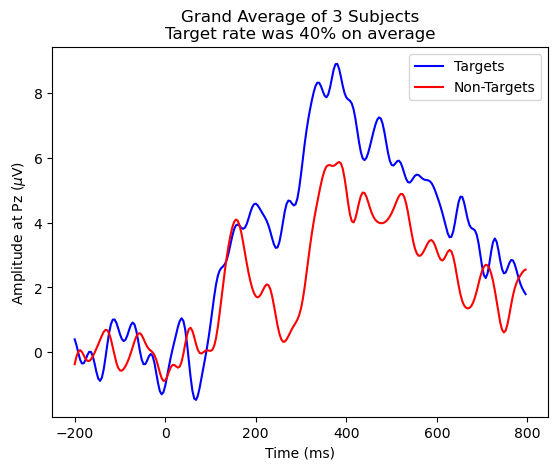

In [4]:
# Compute and plot grand averages
# Also reversing polarity since we recorded on the lower rows of the Cyton
tar = -1 * np.mean(np.array(GA_tar), 0)
non_tar = -1 *np.mean(np.array(GA_non_tar), 0)

plt.figure()
plt.plot(tars['bin_times'], tar, 'b', label='Targets')
plt.plot(tars['bin_times'], non_tar, 'r', label='Non-targets')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude at Pz ($\mu$V)')
plt.title('Grand Average of 3 Subjects\nTarget rate was 40% on average')
plt.legend(['Targets', 'Non-Targets'])